# plottingNewAndOldReads.ipynb
## Marcus Viscardi,    January 16, 2023

This script is going to take the methods from finalizingReadAndCoveragePlotting_matplotlib.py and use those to plot the new reads!

In [2]:
import os
import sys
sys.path.insert(0, '/data16/marcus/scripts/nanoporePipelineScripts')
import nanoporePipelineCommon as npCommon
from nanoporeReadPlotting.finalizingReadAndCoveragePlotting_matplotlib import plot_reads, coverage_plotting_5tera

import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt

print(f"Imports done at {npCommon.get_dt(for_print=True)}")

Imports done at 01/16/23 @ 04:37:15 PM


In [3]:
try:
    reads_df_genes = pd.read_parquet(npCommon.find_newest_matching_file(f"./output_files/*_quad5TERA.reads_df.parquet"))
    compressed_df_genes = pd.read_parquet(npCommon.find_newest_matching_file(f"./output_files/*_quad5TERA.compressed_df.parquet"))
    conversion_dict = {"xrn-1-5tera": "oldN2",
                       "xrn-1-5tera-smg-6": "oldS6",
                       "5tera_xrn-1-KD_wt": "newN2",
                       "5tera_xrn-1-KD_smg-5": "newS5",
                       "5tera_xrn-1-KD_smg-6": "newS6",
                       "5tera_xrn-1-KD_smg-7": "newS7",
                       }
    reads_df_genes.replace(conversion_dict, inplace=True)
    compressed_df_genes.replace(conversion_dict, inplace=True)
    print(f"Finished library loading at {npCommon.get_dt(for_print=True)}")
except ValueError:
    reads_df_genes, compressed_df_genes = None, None
    print("Could not find pre-compressed dataframes saved. Try running the first few cells of initialTestingAndScratchPaper.ipynb")

Finished library loading at 01/16/23 @ 04:37:22 PM


For newN2 we are plotting 3 adapted, and 9 unadapted reads.
This is based on the RPM values of t5+:38.57987480830625 & t5-:453.31352899759844
Found entry for Y73B3A.18 (WBGene00022219) on chromosome     X at (48483, 60774) on the '+' strand


Plotting Reads...: 100%|██████████| 12/12 [00:00<00:00, 370.15it/s]


Saving plot to ./output_files/read_plotting/plots_from_Y73B3A.18/230116_readPlotting_Y73B3A.18_newN2_subSampledByRPM + .png/.svg...
Found entry for Y73B3A.18 (WBGene00022219) on chromosome     X at (48483, 60774) on the '+' strand


KeyError: 'X'

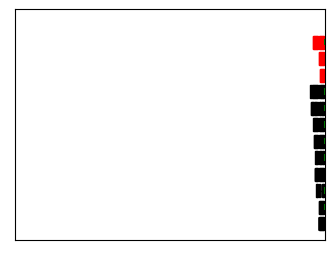

In [14]:
target_gene = 'Y73B3A.18'
divide_factor_base = 50  # Larger number means less reads plotted! Generally 10-500 works well
adapted_adjustment_factor_base = 5  # Larger numbers here mean we'll get proportionally more adapted reads plotted, this is b/c they're so rare normally!

try:
    os.mkdir(f"./output_files/read_plotting/plots_from_{target_gene}")
except FileExistsError:
    pass

bar_plot_dicts = []

for lib in ['newN2', 'newS5', 'newS6', 'newS7', 'oldN2', 'oldS6']:
    if lib.startswith('old'):
        divide_factor = divide_factor_base * 1
        adapted_adjustment_factor =  adapted_adjustment_factor_base / 2
    else:
        divide_factor = divide_factor_base
        adapted_adjustment_factor = adapted_adjustment_factor_base
    # Here I use a round about way to pull the RPM information to normalize the number of reads plotted!
    try:
        adapted_rpm = compressed_df_genes.query(f"lib == '{lib}'").query(f"gene_name == '{target_gene}'").query(f"t5 == '+'")[
            'gene_rpm'].values[0]
    except IndexError:
        # An IndexError would indicate that this place in the dataframe doesn't exist, because of the way these frames were made,
        # if no reads match the parameters, the cell never gets made!! so this indicates there are 0 reads of the searched parameters!
        adapted_rpm = 0
    try:
        unadapted_rpm = compressed_df_genes.query(f"lib == '{lib}'").query(f"gene_name == '{target_gene}'").query(f"t5 == '-'")[
            'gene_rpm'].values[0]
    except IndexError:
        unadapted_rpm = 0
    
    num_adapt_to_plot = int(adapted_rpm / (divide_factor / adapted_adjustment_factor))
    num_unadpt_to_plot = int(unadapted_rpm / divide_factor)
    
    print(f"For {lib} we are plotting {num_adapt_to_plot} adapted, and {num_unadpt_to_plot} unadapted reads.\nThis is based on the RPM values of t5+:{adapted_rpm} & t5-:{unadapted_rpm}")
    plot_reads(reads_df_genes.query(f"lib == '{lib}'"), gene_name_to_plot=target_gene,
               pad_x_axis_bounds_by=50,
               # subsample_fraction=0.125,
               t5_pos_count=num_adapt_to_plot, t5_neg_count=num_unadpt_to_plot,
               only_keep_reads_matched_to_gene=True, plot_width_and_height=(4, 3),
               save_dir=f"./output_files/read_plotting/plots_from_{target_gene}", save_suffix=f"_{lib}_subSampledByRPM")
    coverage_plotting_5tera(reads_df_genes.query(f"lib == '{lib}'"),
                            gene_name=target_gene,
                            save_dir=f"./output_files/read_plotting/plots_from_{target_gene}", save_suffix=f"_{lib}",
                            rpm_normalize=True,
                            )
    
    bar_plot_dicts.append({"gene_name": target_gene,
                           "lib": lib,
                           "unadapted_rpm": unadapted_rpm,
                           "adapted_rpm": adapted_rpm})

sea.set_style("whitegrid")
pd.DataFrame(bar_plot_dicts).set_index('lib').plot(kind='bar', stacked=True, color=['steelblue', 'red'])
bar_plot_save_path = f"./output_files/read_plotting/plots_from_{target_gene}/{npCommon.get_dt()}_geneRPMS_{target_gene}"
for file_type in ['.png', '.svg']:
    plt.savefig(bar_plot_save_path + file_type)